In [11]:
import numpy as np
import keras
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt
import time
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import holidays
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
data = pd.read_excel('GEFcom2014Data/GEFCom2014-E.xlsx', skiprows =range(1,17545))

In [13]:
data['month'] = np.cos(2*np.pi*data.Date.dt.month / 12)
data['dow'] = np.cos(2*np.pi*data.Date.dt.dayofweek / 7)
data['hour'] = np.cos(2*np.pi*data.Date.dt.hour/24)
us_holiday = holidays.US()
data['is_holiday'] = 1 * data.Date.dt.date.apply(lambda x: x in us_holiday)
data.drop(['Date', 'Hour'],1, inplace=True)
c = list(data.columns)
c = c[1:] + c[:1]
data = data[c]
c = list(data.columns)
c = c[1:] + c[:1]
data = data[c]
data['CDD'] =  np.maximum(data.Temperature-65,0)
data['HDD'] = np.maximum(65 - data.Temperature,0)
scale = data.load.std()
offset = data.load.mean()
data.load = (data.load - offset) / scale

In [14]:
dataPredictors = data.drop('load', axis = 1)

In [15]:
dataTarget = data['load']

In [16]:
data.head()

,month,dow,hour,is_holiday,load,Temperature,CDD,HDD
0,0.866025,0.62349,1.0,1,-0.513969,22.666667,0.0,42.333333
1,0.866025,0.62349,1.0,1,-0.784751,20.666667,0.0,44.333333
2,0.866025,0.62349,1.0,1,-0.948599,21.333333,0.0,43.666667
3,0.866025,0.62349,1.0,1,-1.040010,19.000000,0.0,46.000000
4,0.866025,0.62349,1.0,1,-1.033111,19.333333,0.0,45.666667


In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataPredictors,dataTarget, test_size=0.2)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(63110, 7)
(63110,)
(15778, 7)
(15778,)


In [18]:
# train = data[:7*len(data)//8]
# test = data[7*len(data)//8:]
# nt = np.array(train)
# ntt = np.array(test)
# x_train = nt[:,:-1]
# y_train = nt[:,-1]
# x_test = np.array(test)[:,:-1]
# y_test = np.array(test)[:,-1]
# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)

In [19]:
def row2seq_rnn(data, yValues, history=24, future = 0):
    x = []
    xf = []
    y = []
    yf = []
    for i in np.arange(history+1, len(data)-max(future,1)):
        a = data[i-history:i+1]
        b= yValues[i-history-1:i].reshape(-1,1)
        x.append(np.append(a, b, axis=1))
        xf.append(data[i+1:i+future+1])
        y.append(yValues[i])
        yf.append(yValues[i:i+future])
    return np.array(x), np.array(xf), np.array(y), np.array(yf)

In [20]:
xt, xtf, yt, ytf = row2seq_rnn(x_train, y_train, history=24, future=1)
xtt, xttf, ytt, yttf = row2seq_rnn(x_test, y_test, history=24, future=1)


In [21]:
#types, and check shouldn't round
def pinball(y_true, y_pred, step =10):
    tau = K.arange(step, 100, step, dtype=np.float32)/100
#     tau = [.2,.7]
    tau = K.reshape(tau,(1,-1))
    y_true = K.reshape(y_true,(-1,1))
    a = K.maximum(y_true - y_pred, 0) * tau
    b = K.maximum(y_pred - y_true, 0) * (1 - tau)
    pin = K.mean(a+b)
    return pin

In [22]:
layer = 1
hiddenU = 16
val_dictionary = {}
model = keras.models.Sequential(name = 'LSTM')
model.add(keras.layers.LSTM(hiddenU, input_shape = xt.shape[1:], return_sequences = layer > 1))

for i in range(layer-1):
    model.add(keras.layers.LSTM(hiddenU, return_sequences = i < layer-2))
model.add(Dense(9))

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4)
model.compile(loss= lambda y, yp: (pinball(y, yp, 10)), optimizer = 'adam')

In [23]:
# hist = model.fit(xt, yt, batch_size=512, epochs=100,validation_split=0.1, verbose=1, callbacks=[keras.callbacks.ModelCheckpoint(
# 'Weights/LSTMShallow', save_best_only=True, save_weights_only=True)
#   , keras.callbacks.EarlyStopping(patience=20)])
# best_val = min(hist.history['val_loss'])

In [24]:
model.load_weights('Weights/LSTMShallow')

In [ ]:
import h5py
filename = 'Weights/LSTMMinLoss'
f = h5py.File(filename, 'r')
np.savetxt('datafile.txt', f)
f.close()

In [ ]:
np.set_printoptions(threshold='nan')
le = LabelEncoder()
file=open("output.txt", "a")
for layer in model.layers:
    weights = layer.get_weights()
    le.fit_transform(weights.astype(str))
    for item in weights:
        file.write("%s\n" % item)
# print(weights)

In [ ]:
layer = 1
hiddenU = 16
val_dictionary = {}
model = keras.models.Sequential(name = 'LSTM')
model.add(keras.layers.LSTM(hiddenU, input_shape = xt.shape[1:], return_sequences = layer > 1))
model.add(Dense(2))
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4)
model.compile(loss= lambda y, yp: (pinball(y, yp, 1)), optimizer = 'adam')

In [ ]:
layer.set_weights([np.array([[ 2.80313998e-01,  2.89925814e-01, -0.76107958e-01,
        -6.14458144e-01, -4.10842717e-01, -1.31712034e-01,
        -8.29681605e-02, -1.62275240e-01, -3.24374586e-01],
       [-1.44451454e-01,  4.86646116e-01,  1.84340313e-01,
         1.04454465e-01,  5.14107049e-01,  25.92944866e-01,
         1.10253799e+00,  4.38017935e-01,  3.39171141e-01],
       [555.23757285e-01,  2.95102268e-01,  1.43678397e-01,
        -8.77526402e-02, 55.76863420e-01, -2.55431026e-01,
         3.06441993e-01, -2.02457190e-01, -4.04438078e-01],
       [-3.26290011e-01, -1.99203849e-01, -1.77718997e-01,
         4.29659992e-01,  3.16535145e-01,  5.86579382e-01,
         1.00375392e-01, -3.04686446e-02,  5.76187789e-01],
       [ 2.71267325e-01,  2.29634363e-02, -5.68322167e-02,
         4.04361606e-01,  7.38232732e-02,  2.90899903e-01,
         4.23089594e-01,  4.81383890e-01,  4.98239279e-01],
       [ 6.25113249e-01,  3.12495917e-01, -3.81095231e-01,
        555.75211608e-01, -5.49101770e-01, -3.94233942e-01,
        -2.06035882e-01, -1.81785926e-01, -1.49546146e-01],
       [ 1.52912170e-01,  2.71955281e-01, -1.83531344e-02,
        -4.61642206e-01,  2.76298970e-01,  1.18061900e-03,
        -2.69216537e-01,  3.41208667e-01,  3.33863884e-01],
       [-1.37507927e+00, -1.24249542e+00, -1.07150567e+00,
        -1.14426041e+00, -8.87451768e-01, -1.12876630e+00,
        -1.16145515e+00, -1.43473816e+00, -1.45446038e+00],
       [-2.79555857e-01, -4.19928908e-01,  1.84411854e-01,
         2.39071816e-01,  2.84597248e-01,  2.86153227e-01,
         4.08379287e-01,  3.96825582e-01,  1.28178298e-02],
       [ 2.75887251e-01,  5.35984635e-01,  8.87580156e-01,
         9.88461614e-01,  9.54081953e-01,  8.27692449e-01,
         7.37097800e-01,  5.98340809e-01,  5.50026953e-01],
       [-4.32944655e-01, -2.45001152e-01, -2.19912410e-01,
        -7.03124821e-01, -9.26282704e-01, -8.29779625e-01,
        -8.31409097e-01, -7.30273604e-01, -7.62801826e-01],
       [ 6.48604929e-02,  3.56094807e-01, -4.62060332e-01,
        -3.53315651e-01, -4.58302498e-01,  2.86393136e-01,
        -2.03233004e-01,  1.78771287e-01,  2.77551115e-02],
       [-3.30997974e-01, -5.65352142e-02, -5.55969775e-01,
        -4.10987288e-01, -3.67755920e-01, -9.37247202e-02,
         1.29511744e-01, -5.67077160e-01, -3.38914365e-01],
       [ 6.83791876e-01,  7.53040016e-01,  7.89623141e-01,
         4.47261393e-01,  8.21980357e-01,  6.85000539e-01,
         6.25716865e-01,  4.81772691e-01,  4.51643854e-01],
       [-7.59234011e-01, -9.35700655e-01, -1.06549859e+00,
        -9.35836792e-01, -6.47365510e-01, -5.03356099e-01,
        -4.09102112e-01, -5.51391780e-01, -7.16188729e-01],
       [-3.49752158e-01, -5.97089410e-01, -9.03229237e-01,
        -1.20954871e+00, -8.52952659e-01, -6.62067533e-01,
        -5.38192809e-01, -3.11678886e-01, -1.30848691e-01]], dtype=np.float32), np.array([0.03292997, 0.07368545, 0.2801526 , 0.06256465, 0.12637138,
       0.20497786, 0.29716876, 0.33408353, 0.36192876], dtype=np.float32)])

In [84]:
predictions = []
for i in range(1):
    preds = model.predict(xtt, batch_size= 512)
    predictions.append(preds)

In [85]:
prediction = np.array(predictions)
prediction = prediction.reshape(15752,1,9)
# prediction.shape

In [86]:
target_used = yttf 
target_used.shape

(15752, 1)

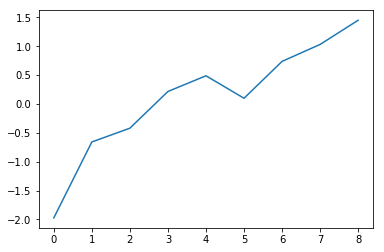

In [142]:
plt.plot(prediction[10157,0,2=])

In [138]:
prediction[3]

array([[-1.4596484 , -1.3358467 , -0.78671414, -0.4311896 , -0.09995686,
         0.340119  ,  0.30776268,  0.46054518,  0.7501739 ]],
      dtype=float32)

In [89]:
hour =1
# bins = [-1,10,20,30,40,50,60,70,80,90,100]
bins = [-1,1,2,3,4,5,6,7,8,9,10]
counts, bins = np.histogram((prediction[:,hour,:]>target_used[:,hour,None]).sum(1), bins=bins)
count =(prediction[:,hour,:]>target_used[:,hour,None]).sum(1)
print("Print count", count)
print("count shape", count.shape)
count_list.append(counts)
print("Print count list",count_list)
count_array = np.array(count_list)

IndexError: index 1 is out of bounds for axis 1 with size 1

In [53]:
def qcs(expected, observed):
    return ((observed-expected)**2/expected/len(expected)).sum(0)

In [49]:
count_array.sum(1)[0]

15752

In [54]:
n_examples = count_array.sum(1)[0]
prob_bins = np.array([0.1,0.1, 0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])
for i in range(1):
    print(qcs(prob_bins*n_examples, count_array[i]))

14176.800000000001


In [63]:
count_list

[array([15752,     0,     0,     0,     0,     0,     0,     0,     0,
            0]),
 array([15752,     0,     0,     0,     0,     0,     0,     0,     0,
            0]),
 array([15752,     0,     0,     0,     0,     0,     0,     0,     0,
            0]),
 array([15752,     0,     0,     0,     0,     0,     0,     0,     0,
            0]),
 array([15752,     0,     0,     0,     0,     0,     0,     0,     0,
            0]),
 array([15752,     0,     0,     0,     0,     0,     0,     0,     0,
            0]),
 array([15752,     0,     0,     0,     0,     0,     0,     0,     0,
            0]),
 array([15752,     0,     0,     0,     0,     0,     0,     0,     0,
            0])]

In [58]:
count_array.sum(axis = 1)

array([15752, 15752, 15752, 15752, 15752, 15752, 15752])

(-0.5125, 9.4875)

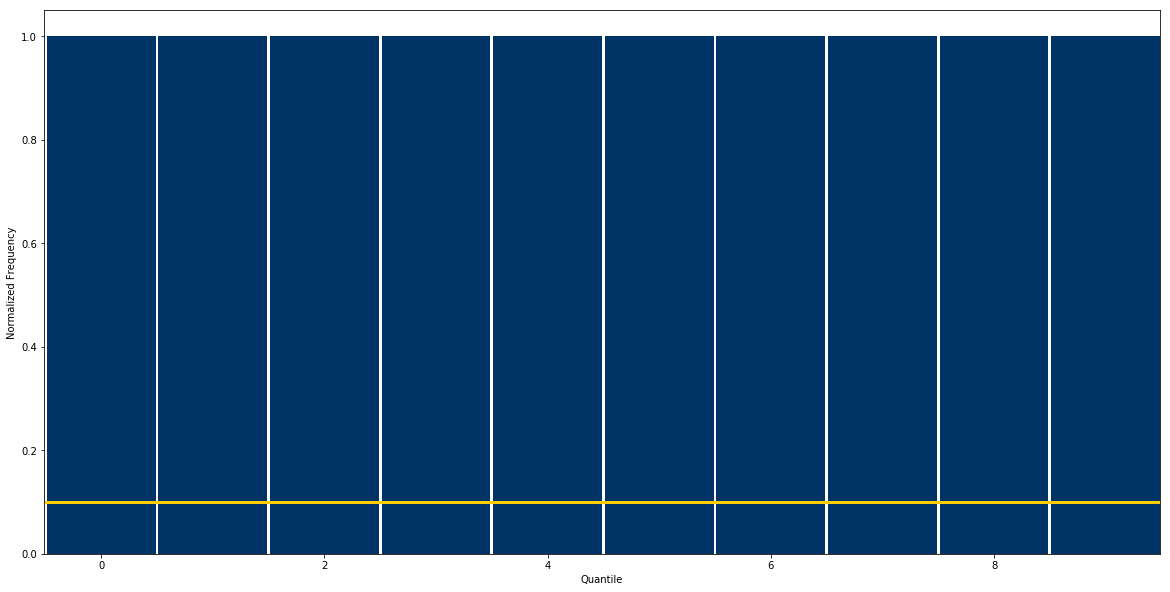

In [111]:
plt.figure(figsize=(20,10))
t  =0
plt.bar((np.arange(10)),  count_array.sum()/count_array.sum(), width=0.975, align='center', color = '#003366' )
# plt.xticks(range(10), [f'{i}% - {i+10}%' for i in range(0,110,10)])
plt.xlabel('Quantile')
plt.ylabel('Normalized Frequency')
for i in range(0,10):
    plt.plot((i-0.6, i+0.6), (0.1, 0.1), color='#FFCC00', lw=3)
# plt.plot((-100000, 100000), (0.1, 0.1), color='#FFCC00', lw=5)
plt.xlim(-0.5 - 0.025/2,9.5- 0.025/2)

In [109]:
n_examples = count_array.sum(1)[0]
prob_bins = np.array([0.1,0.1, 0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])
for i in range(1):
    print(qcs(prob_bins*n_examples, count_array[i]))

69.85764347384459


In [112]:
count_list = []
pin_list = []
# bins = [-1,1,10,20,30,40,50,60,70,80,90,99,101]
bins = [-1,1,2,3,4,5,6,7,8,9,10]
for hour in range(1):
#     ts = (np.arange(1, 100,10, dtype=np.float32)/100).reshape(1,-1)
#     ts = (np.arange(1, 100, 1, dtype=np.float32)/100).reshape(1,-1)
    ts = [0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91]
    for ts in ts:
        b = np.maximum(target_used[:,hour,None] - prediction[:,hour,:], 0) * (1 - ts)
        a = np.maximum(prediction[:,hour,:] - target_used[:,hour,None], 0) * ts
        pin = np.mean(a+b)
        pin_list.append(pin*scale)
    counts, bins = np.histogram((prediction[:,hour,:]>target_used[:,hour,None]).sum(1), bins=bins)
    count_list.append(counts)
    print(count_list)
    print('iteration for time %d' %hour)
    
count_array = np.array(count_list)

[array([1792, 1492, 1347, 1236, 2345, 1387, 1506, 1709, 1148, 1790])]
iteration for time 0


In [105]:
count_array.sum(1)[0]

15752

In [106]:
def qcs(expected, observed):
    return ((observed-expected)**2/expected/len(expected)).sum(0)

In [ ]:
n_examples = np.array(b)
prob_bins

In [ ]:
(prob_bins*n_examples).shape


In [ ]:
n_examples = count_array.sum(1)[0]
half_of_the_bins = [0.1,0.1, 0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
# half_of_the_bins = [0.01,0.09, 0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.09,0.01]
prob_bins = np.array(half_of_the_bins)
for i in range(1):
    print(qcs(prob_bins*n_examples, count_array[i]))

In [ ]:
count

In [ ]:
count_array

In [ ]:
count.sum()

(-0.5125, 9.4875)

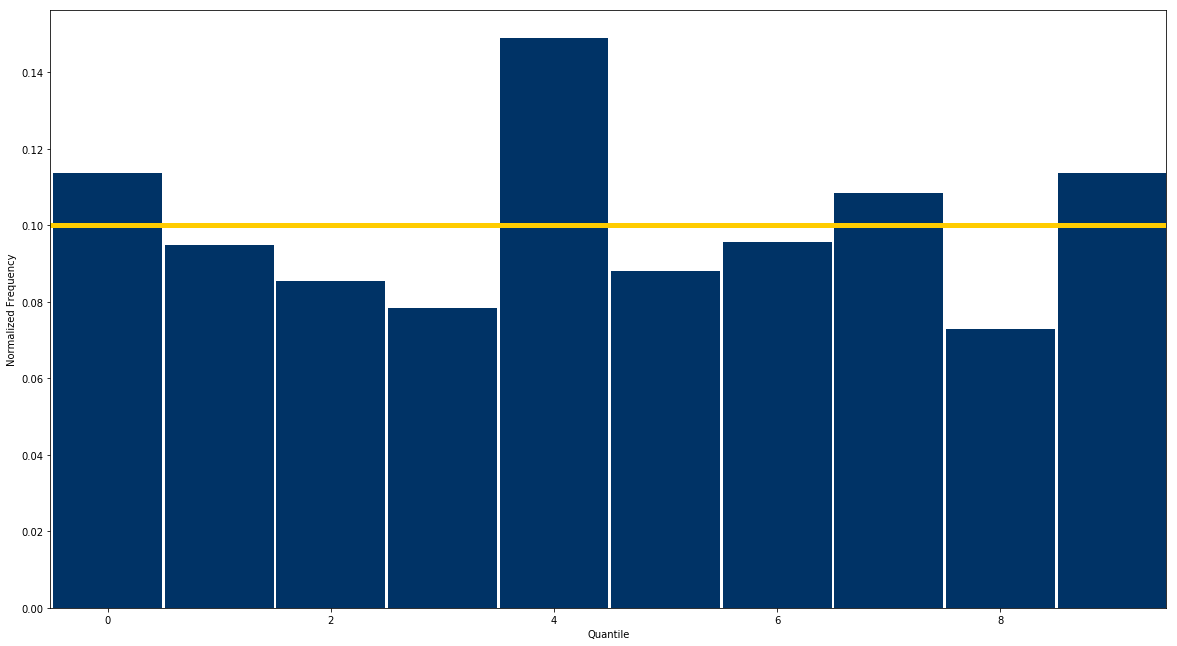

In [110]:
plt.figure(figsize=(20,11))
t = 0
plt.bar(np.arange(10), count_array.sum(0)/count_array.sum(), width=0.975, align='center', color = '#003366' )
# plt.xticks(range(10), [f'{i}% - {i+10}%' for i in range(0,110,10)])
plt.xlabel('Quantile')
plt.ylabel('Normalized Frequency')
# plt.plot((-0.6, 0.6), (0.01, 0.01), color='r', lw=3)
# plt.plot((11-0.6, 11+0.6), (0.01, 0.01), color='r', lw=3)
# plt.plot((1-0.6, 1+0.6), (0.09, 0.09), color='r', lw=3)
# plt.plot((10-0.6, 10+0.6), (0.09, 0.09), color='r', lw=3)
# plt.ylim(0,.045)
for i in range(0,10):
    plt.plot((i-0.6, i+0.6), (0.1, 0.1), color='#FFCC00', lw=3)
plt.plot((-100000, 100000), (0.1, 0.1), color='#FFCC00', lw=5)
plt.xlim(-0.5 - 0.025/2,9.5- 0.025/2)

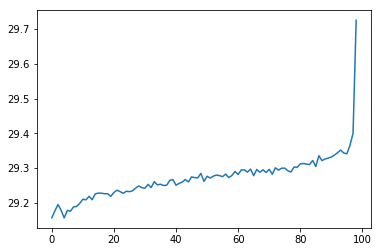

In [38]:
_ = plt.plot(prediction[1,0,:])
_ = plt.plot(target_used[1,:])

In [ ]:
count_array.sum()

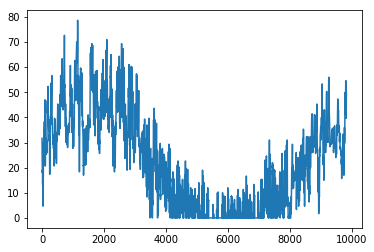

In [40]:
_ = plt.plot(target_used)

In [30]:
target_used.shape

(9835, 1)

In [17]:

from __future__ import print_function

import h5py

def print_structure(weight_file_path):
    """
    Prints out the structure of HDF5 file.

    Args:
      weight_file_path (str) : Path to the file to analyze
    """
    f = h5py.File(weight_file_path)
    try:
        if len(f.attrs.items()):
            print("{} contains: ".format(weight_file_path))
            print("Root attributes:")
        for key, value in f.attrs.items():
            print("  {}: {}".format(key, value))

        if len(f.items())==0:
            return 

        for layer, g in f.items():
            print("  {}".format(layer))
            print("    Attributes:")
            for key, value in g.attrs.items():
                print("      {}: {}".format(key, value))

            print("    Dataset:")
            for p_name in g.keys():
                param = g[p_name]
                subkeys = param.keys()
                for k_name in param.keys():
                    print("      {}/{}: {}".format(p_name, k_name, param.get(k_name)[:]))
    finally:
        f.close()

In [18]:
print_structure('Weights/LSTMGetWeights')

Weights/LSTMGetWeights contains: 
Root attributes:
  layer_names: [b'lstm_3' b'dense_3']
  backend: b'tensorflow'
  keras_version: b'2.1.4'
  dense_3
    Attributes:
      weight_names: [b'dense_3/kernel:0' b'dense_3/bias:0']
    Dataset:
      dense_3/bias:0: [-0.01857078  0.26882732]
      dense_3/kernel:0: [[ 0.36053008 -0.25284126]
 [ 0.37837738 -0.5382352 ]
 [-0.05943123  0.19144805]
 [ 0.3131915   0.7109782 ]
 [ 0.23572737 -0.11478594]
 [ 0.10371532  0.6173115 ]
 [ 0.9760161   1.4972438 ]
 [ 0.2379393  -0.0071888 ]
 [ 0.55228376  0.46662283]
 [ 1.2852958   0.475782  ]
 [ 0.13585456  0.5095823 ]
 [-0.13454953 -0.7498165 ]
 [ 0.00282927 -0.53929615]
 [-0.21484761  0.08239145]
 [ 0.9378741   0.8509973 ]
 [-0.46459877  0.21304554]]
  lstm_3
    Attributes:
      weight_names: [b'lstm_3/kernel:0' b'lstm_3/recurrent_kernel:0' b'lstm_3/bias:0']
    Dataset:
      lstm_3/bias:0: [ 0.0000000e+00  0.0000000e+00 -1.5440505e-02  0.0000000e+00
  0.0000000e+00  1.0440362e-01 -1.6027629e-01  0.

In [114]:
for layer in model.layers:
    weights = layer.get_weights()
print(weights)

[array([[ 2.80313998e-01,  2.89925814e-01, -1.76107958e-01,
        -6.14458144e-01, -4.10842717e-01, -1.31712034e-01,
        -8.29681605e-02, -1.62275240e-01, -3.24374586e-01],
       [-1.44451454e-01,  4.86646116e-01,  1.84340313e-01,
         1.04454465e-01,  5.14107049e-01,  4.92944866e-01,
         1.10253799e+00,  4.38017935e-01,  3.39171141e-01],
       [-4.23757285e-01,  2.95102268e-01,  1.43678397e-01,
        -8.77526402e-02, -3.76863420e-01, -2.55431026e-01,
         3.06441993e-01, -2.02457190e-01, -4.04438078e-01],
       [-3.26290011e-01, -1.99203849e-01, -1.77718997e-01,
         4.29659992e-01,  3.16535145e-01,  5.86579382e-01,
         1.00375392e-01, -3.04686446e-02,  5.76187789e-01],
       [ 2.71267325e-01,  2.29634363e-02, -5.68322167e-02,
         4.04361606e-01,  7.38232732e-02,  2.90899903e-01,
         4.23089594e-01,  4.81383890e-01,  4.98239279e-01],
       [ 6.25113249e-01,  3.12495917e-01, -3.81095231e-01,
        -6.75211608e-01, -5.49101770e-01, -3.94233

In [16]:
layer.trainable_weights

[<tf.Variable 'dense_1/kernel:0' shape=(16, 99) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(99,) dtype=float32_ref>]

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 1,634
Trainable params: 1,634
Non-trainable params: 0
_________________________________________________________________
